In [1]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction, LinearPauliRotations, PiecewiseLinearPauliRotations
from qiskit_finance.circuit.library import LogNormalDistribution, NormalDistribution
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
import math
import itertools


In [2]:
# setup simulator using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
# IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
# construct circuit for uncertainty modeler.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm = Aer.get_backend('qasm_simulator')
stv = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')

In [3]:
## Helper functions
def plot_dist(prob_dist):
    x = prob_dist.values
    y = prob_dist.probabilities
    plt.figure(figsize= (12,5))
    plt.bar(x, y, width=0.2)
    plt.xticks(x, size=15, rotation=90)
    plt.yticks(size=15)
    plt.grid()
    plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
    plt.ylabel("Probability ($\%$)", size=15)
    plt.show()

def plot_payoff(prob_dist_circuit, strike_price):
    x = prob_dist_circuit.values
    y = np.maximum(0, x - strike_price)
    plt.figure(figsize= (12,5))
    plt.plot(x, y, "bo-")
    plt.grid()
    plt.title("Payoff Function", size=15)
    plt.xlabel("Spot Price", size=15)
    plt.ylabel("Payoff", size=15)
    plt.xticks(x, size=15, rotation=90)
    plt.yticks(size=15)
    plt.show()
    

### European Option Pricing

#### State prpeparation

##### Distribution Loading

In [40]:
num_uncertainty_qubits = 5

# parameters for considered random distribution
S = 3.0  # initial spot price
vol = 0.3  # volatility of 40%
r = 0.08  # annual interest rate of 4%
T = 60 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

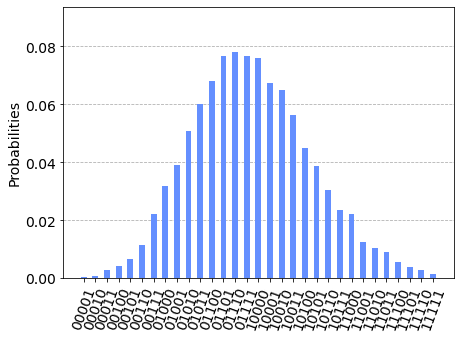

In [41]:
uncertainty_model.measure_all()
plot_histogram( execute(uncertainty_model, aer, shots= 10024 ).result().get_counts() ,bar_labels= False, sort='asc')

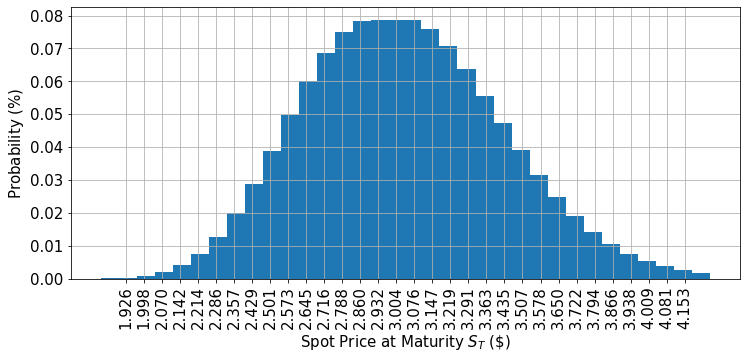

In [43]:
plot_dist(uncertainty_model)

##### Payoff function loading

In [45]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2.654

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
    name= "Payoff"
)





# ## set strike price ~
# strike_price = 2.654

# ## set approximation ratio ~
# c_aprx = 0.25

# ## set payoff function  ~
# breakpoints = [low, strike_price]
# slopes = [0, 1 ]
# offsets = [0 ,0 ]
# fmin = 0
# fmax =  high - strike_price
# option_objective = LinearAmplitudeFunction(num_qubits_dist, slopes, offsets, domain= (low, high), rescaling_factor= c_aprx , image = (fmin, fmax), breakpoints= breakpoints, name="Payoff" )

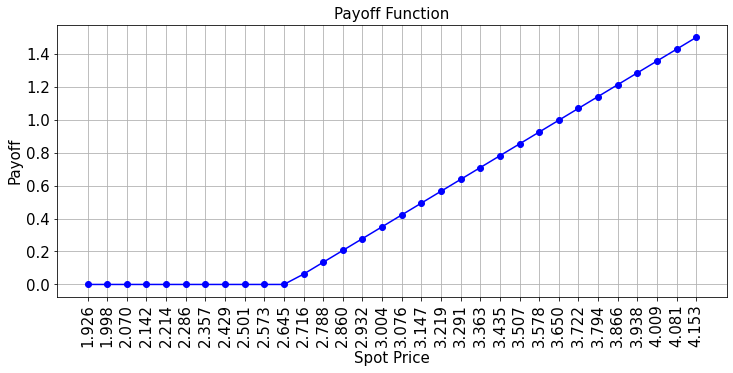

In [47]:
plot_payoff(uncertainty_model, strike_price)

In [32]:
# option_objective.measure_all()
# plot_histogram(execute(option_objective, backend= qsm).result().get_counts() )

In [48]:
# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

# option_circuit = QuantumCircuit( option_objective.num_qubits)
# option_circuit.append(prob_dist_circuit, range(num_qubits_dist))
# option_circuit.append(option_objective, range(option_objective.num_qubits))
# # creg = ClassicalRegister(1, name= 'creg')
# # option_circuit.add_register(creg)

# option_circuit.draw()

┌───────┐┌──────────┐
 q_0: ┤0      ├┤0         ├
      │       ││          │
 q_1: ┤1      ├┤1         ├
      │       ││          │
 q_2: ┤2 P(X) ├┤2         ├
      │       ││          │
 q_3: ┤3      ├┤3         ├
      │       ││          │
 q_4: ┤4      ├┤4         ├
      └───────┘│          │
 q_5: ─────────┤5  Payoff ├
               │          │
 q_6: ─────────┤6         ├
               │          │
 q_7: ─────────┤7         ├
               │          │
 q_8: ─────────┤8         ├
               │          │
 q_9: ─────────┤9         ├
               │          │
q_10: ─────────┤10        ├
               └──────────┘

In [34]:
# option_circuit.measure(option_circuit.qubits[0], creg)
# option_circuit.measure_all()
# option_circuit.draw()
# # plot_histogram( execute(option_circuit, backend= qsm, shots= 1024).result().get_counts() )

In [49]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.1

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[5],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
# estimation = EstimationProblem(state_preparation= option_circuit, objective_qubits= [num_qubits_dist], post_processing= option_objective.post_processing, )
# iqae_alg = IterativeAmplitudeEstimation( epsilon, alpha, quantum_instance= QuantumInstance(Aer.get_backend("aer_simulator"), shots= 100))

In [50]:
result = ae.estimate(problem)

CircuitError: 'inverse() not implemented for measure.'

In [ ]:
execute(option_circuit , backend= qsm)

DAGCircuitError: 'expected 5 wires, got 10'

In [ ]:
option_circuit.qubits, option_circuit.data

([Qubit(QuantumRegister(11, 'q'), 0),
  Qubit(QuantumRegister(11, 'q'), 1),
  Qubit(QuantumRegister(11, 'q'), 2),
  Qubit(QuantumRegister(11, 'q'), 3),
  Qubit(QuantumRegister(11, 'q'), 4),
  Qubit(QuantumRegister(11, 'q'), 5),
  Qubit(QuantumRegister(11, 'q'), 6),
  Qubit(QuantumRegister(11, 'q'), 7),
  Qubit(QuantumRegister(11, 'q'), 8),
  Qubit(QuantumRegister(11, 'q'), 9),
  Qubit(QuantumRegister(11, 'q'), 10)],
 [(Instruction(name='P(X)', num_qubits=5, num_clbits=5, params=[]), [Qubit(QuantumRegister(11, 'q'), 0), Qubit(QuantumRegister(11, 'q'), 1), Qubit(QuantumRegister(11, 'q'), 2), Qubit(QuantumRegister(11, 'q'), 3), Qubit(QuantumRegister(11, 'q'), 4)], []), (Instruction(name='Payoff', num_qubits=11, num_clbits=0, params=[]), [Qubit(QuantumRegister(11, 'q'), 0), Qubit(QuantumRegister(11, 'q'), 1), Qubit(QuantumRegister(11, 'q'), 2), Qubit(QuantumRegister(11, 'q'), 3), Qubit(QuantumRegister(11, 'q'), 4), Qubit(QuantumRegister(11, 'q'), 5), Qubit(QuantumRegister(11, 'q'), 6), Qub